In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy_indexed as npi
from labellines import labelLines
import os
import sys

'''
Script to compare litos and stability setup JV scan pixel by pixel
replace file path below
'''

# litos_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\Litos_analyzed\0\Data\photo - 0p_0.0Sun_Scan0.txt"
# ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\0p\Nov-08-2023 15_57_40lightID1scan.csv"



'\nScript to compare litos and stability setup JV scan pixel by pixel\nreplace file path below\n'

C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-30-2025 18_02_22 leo devices 3 no silver\devices_sms_holder\2


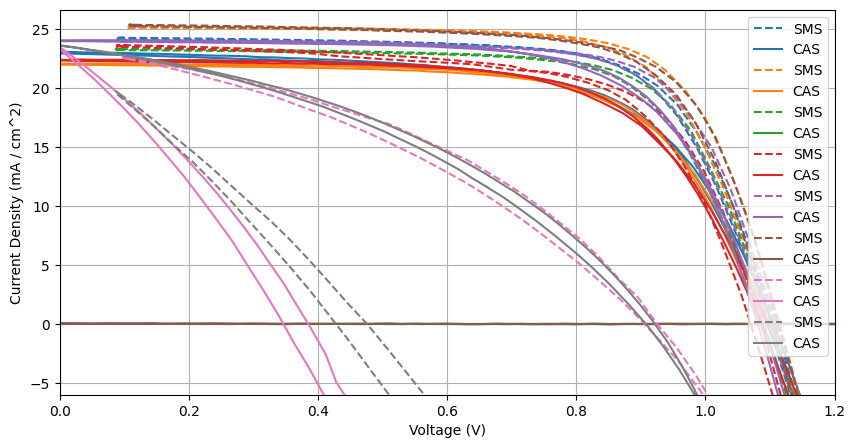

FF diff foward 0.23853175102591723, FF diff Reverse0.2591307822678011
voc diff forward 0.23297525402642383, voc diff reverse 0.21690046592035997
average ff diff:  0.24883126664685917
average voc diff: 0.22493785997339188
C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-30-2025 18_02_22 leo devices 3 no silver\devices_sms_holder\3


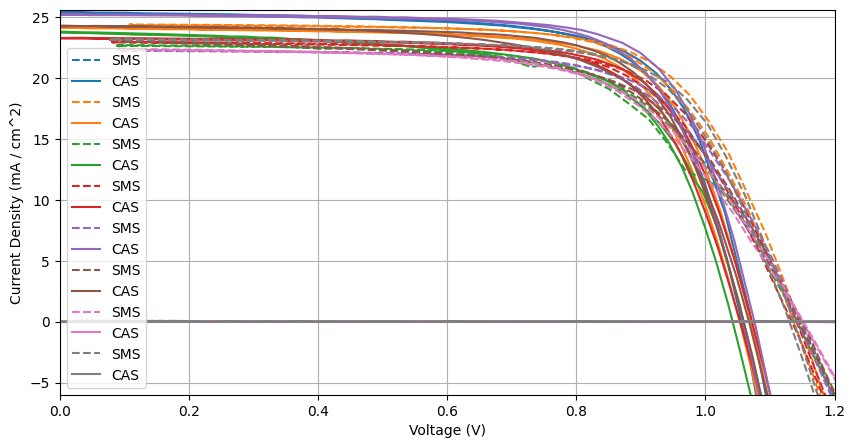

FF diff foward 1.9775458909523647, FF diff Reverse1.6740221123275594
voc diff forward 0.18089186772600363, voc diff reverse 0.20792170914308988
average ff diff:  1.825784001639962
average voc diff: 0.19440678843454676


C:\Users\achen\AppData\Local\Temp\ipykernel_32292\1779308957.py:252: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_plot_data_ff, labels=labels_ff)


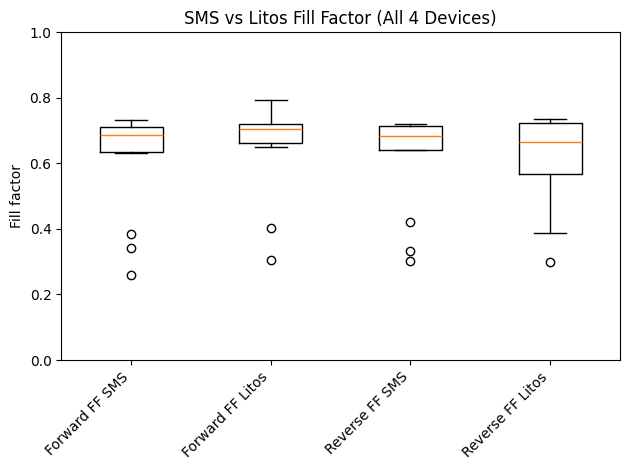

C:\Users\achen\AppData\Local\Temp\ipykernel_32292\1779308957.py:267: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_plot_data_voc, labels=labels_voc)


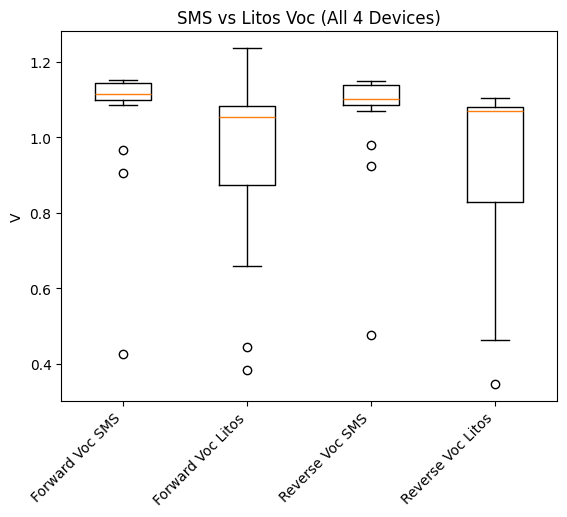

[[0.7082695291611328, 0.732082778118784, 0.7193041475008486, 0.6713533045649211, 0.7265213531611758, 0.7154799726367128, 0.38562006727844766, 0.3414901912378827, 0.2599841786453075, 0.7009104768089146, 0.6309371126818917, 0.6890291018951692, 0.6837172496768861, 0.6373045883119809, 0.6404597645753408, 0.7103834801336611], [0.6513156393585899, 0.6799473775589359, 2.264836684196419, 0.6656559640917847, 0.6979771116612, 0.7944069487285171, 0.30576872690888934, 0.4021024739527844, 0.7137612924604722, 0.7166891747773809, 0.6776758326794954, 0.716126546651008, 0.7240966102288322, 0.720112461031861, 12.226399831776476, -2.8574643704752214], [0.714953681031498, 0.7210898816553053, 0.7112498469825429, 0.6689910452944382, 0.7182212117846407, 0.7124165500678215, 0.4212911743034999, 0.33204464630349717, 0.30297194110225456, 0.693925100126167, 0.6487135634537998, 0.6833663546741634, 0.683763257381691, 0.6399248356739311, 0.6420991738620266, 0.713587762245883], [0.6286980147015874, 0.660243273815726,

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy_indexed as npi
from labellines import labelLines
from matplotlib.font_manager import FontProperties
np.set_printoptions(linewidth=100)   # or pick a big number, e.g. 200
import os
import sys
import re
from scipy.interpolate import interp1d	 # pip install scipy

# def get_stats_arr(voltage, current):


def get_stats(voltage, current):
	ff_all = []
	jsc_all = []
	voc_all = []
	for i in range(voltage.shape[1]):
		V = np.asarray(voltage[:, i])
		I = np.asarray(current[:, i])
		if V.shape != I.shape:
			raise ValueError("voltages and currents must have the same shape")

		# 1) Voc: interpolate V at I=0
		#    Sort by current for reliable interpolation
		sort_I = np.argsort(I)
		I_sorted = I[sort_I]
		V_sorted_by_I = V[sort_I]
		Voc = float(np.interp(0.0, I_sorted, V_sorted_by_I))

		# 2) Isc: interpolate I at V=0
		sort_V = np.argsort(V)
		V_sorted = V[sort_V]
		I_sorted_by_V = I[sort_V]
		Isc = float(np.interp(0.0, V_sorted, I_sorted_by_V))

		# 3) Maximum power point
		P = V * I
		idx_mp = np.argmax(P)
		Vmp = float(V[idx_mp])
		Imp = float(I[idx_mp])

		# 4) Fill Factor
		FF = (Vmp * Imp) / (Voc * Isc) if (Voc * Isc) != 0 else np.nan

		ff_all.append(FF)
		jsc_all.append(Isc)
		voc_all.append(Voc)


	return np.array(ff_all), np.array(jsc_all), np.array(voc_all)

def plot_difference(ss_file_path, litos_directory, litos_str, plot_size):
	# litos_directory = ""
	# litos_directory = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\2025-03-04-- Litos New PCB 4 Device comparison\devices\device_2"

	all_files = []

	if litos_directory != "":
		print(litos_directory)
		for root, dirs, files in os.walk(litos_directory):
			for file in files:
				if file.endswith('.csv'):
					file_path = os.path.join(root, file)
					all_files.append(file_path)

	litos_voltage = []
	litos_current = []

	# Process each file
	for file_path in all_files:
		if litos_str in file_path:
			try:
				data = np.genfromtxt(
					file_path,
					delimiter=',',
					comments='#',
					skip_header=0,
					encoding='cp1252'  # Specify the correct encoding
				)
				voltage = data[:, 0]
				current = data[:,1] / 0.128

				mask		   = np.isfinite(voltage) & np.isfinite(current)
				voltage_clean  = voltage[mask]
				current_clean  = current[mask]

				litos_voltage.append(voltage_clean)
				litos_current.append(current_clean)
			except Exception as e:
				print(f"Error processing {file_path}: {e}")

	litos_voltage = np.array(litos_voltage).T
	litos_current = np.array(litos_current).T

	np.set_printoptions(threshold=np.inf)
	data = []
	# ss_file_path = ""
	# ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Mar-4-2025 4 device test\Mar-04-2025 16_42_19__4 Device First Test\Mar-04-2025_16-44-53__4 Device First Test__ID2__mppt.csv"
	if ss_file_path != "":
		arr = np.loadtxt(ss_file_path, delimiter=",", dtype=str)
		header_row = np.where(arr == "Time")[0][0]

		meta_data = {}
		for data in arr[:header_row, :2]:
			meta_data[data[0]] = data[1]

		headers = arr[header_row, :]
		arr = arr[header_row + 1 :, :]

		data = arr[:, 2:-1]

		pixel_V = data[:, ::2][:, ::-1].astype(float)
		pixel_mA = data[:, 1::2][:, ::-1].astype(float)/ float(meta_data["Cell Area (mm^2)"])
		# if ("Cell Area (mm^2)" in meta_data):
		#	 pixel_mA /= float(meta_data["Cell Area (mm^2)"])
		# else:
		#	 pixel_mA /= 0.128

	# ax.spines['bottom'].set_position(('data', 0))

	ss_half = pixel_V.shape[0] // 2
	litos_half = litos_voltage.shape[0] // 2

	litos_Fv = litos_voltage[litos_half:,:]
	litos_Fa = litos_current[litos_half:,:]
	ff_litos_f, jsc_litos_f, voc_litos_f = get_stats(litos_Fv, litos_Fa)
	litos_Rv = litos_voltage[:litos_half,:]
	litos_Ra = litos_current[:litos_half,:]
	ff_litos_R, jsc_litos_r, voc_litos_r = get_stats(litos_Rv, litos_Ra)

	sms_Fv = pixel_V[ss_half:,:]
	sms_Fa = pixel_mA[ss_half:,:]
	ff_sms_f, jsc_sms_f, voc_sms_f = get_stats(sms_Fv, sms_Fa)
	sms_Rv = pixel_V[:ss_half,:]
	sms_Ra = pixel_mA[:ss_half,:]
	ff_sms_R, jsc_sms_r, voc_sms_r = get_stats(sms_Rv, sms_Ra)

	colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
	plt.figure(figsize=(plot_size))
	plt.xlim(0,1.2)
	# plt.title(f"Pixel{i}")
	top = max(np.max(pixel_mA), np.max(current))*1.05
	plt.ylim(bottom = -6, top = top)
	plt.xlabel('Voltage (V)')
	plt.ylabel('Current Density (mA / cm^2)')
	plt.grid()
	ax = plt.gca()
	for i in range(8):

		lineName = "SMS"
		if ss_file_path:
			plt.plot(pixel_V[:,i],
					 pixel_mA[:,i],
					 linestyle='--',
					 color=colors[i % len(colors)],
					 label = lineName)
		if True:
			# plt.hlines(pce[i], x_start, x_end, label="litos_pce" + str(i + 1))
			plt.plot(litos_voltage[:,i],
					 litos_current[:,i],
					 color=colors[i % len(colors)],
					 label = "CAS")

		# print(f"litos forward:{ff_litos_f[i]}")
		# print(f"sms forward:{ff_sms_f[i]}")
		# print(f"litos reverse:{ff_litos_R[i]}")
		# print(f"sms reverse:{ff_sms_R[i]}")

		# plt.legend(bbox_to_anchor=(0.25, 0.16))
	plt.legend()
	plt.show()

	ff_diff_forward = np.abs(ff_sms_f - ff_litos_f)
	ff_diff_reverse = np.abs(ff_sms_R - ff_litos_R)
	voc_diff_forward = np.abs(voc_sms_f - voc_litos_f)
	voc_diff_reverse = np.abs(voc_sms_r - voc_litos_r)


	box_plot_data_ff = [ff_sms_f, ff_litos_f,ff_sms_R, ff_litos_R]

	box_plot_data_voc = [voc_sms_f, voc_litos_f, voc_sms_r, voc_litos_r]

	return ff_diff_forward, voc_diff_forward, ff_diff_reverse, voc_diff_reverse, box_plot_data_ff, box_plot_data_voc

files = []
# for i in range(1,5):
# 	files.append([
# 		rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\April-03-2025 litos\devices\{i}",
# 		rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-03-2025 19_18_09\Apr-03-2025_19-18-19__ID{i}__light__scan.csv"
# 	])

r"""
Best performing
for i in range(4,5):

for i in range(4,5):
	files.append([
		rf"C:\Users\Andrew Chen\Dropbox\code\Stability-Setup\data\Apr-10-2025 18_28_52\Litos\devices\{i}",
		rf"C:\Users\Andrew Chen\Dropbox\code\Stability-Setup\data\Apr-10-2025 18_28_52\Apr-10-2025_18-39-43__ID{i}__light__scan.csv"
	])

"""

sms_files = [
	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-30-2025 18_02_22 leo devices 3 no silver\Apr-30-2025_18-04-54__ID1__light__scan.csv",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-30-2025 18_02_22 leo devices 3 no silver\Apr-30-2025_18-19-32__ID2__light__scan.csv",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-30-2025 18_02_22 leo devices 3 no silver\Apr-30-2025_18-19-32__ID3__light__scan.csv",
	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-30-2025 18_02_22 leo devices 3 no silver\Apr-30-2025_18-04-54__ID4__light__scan.csv",
]
litos_files = [

	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-30-2025 18_02_22 leo devices 3 no silver\devices\1",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-30-2025 18_02_22 leo devices 3 no silver\devices_sms_holder\2",
	rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-30-2025 18_02_22 leo devices 3 no silver\devices_sms_holder\3",
	# rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\Apr-30-2025 18_02_22 leo devices 3 no silver\devices\4",
]
for sms, litos in zip(sms_files, litos_files):
	files.append([
	 sms,
	 litos
	])

average_VOC = []
average_FF = []
box_plot_data_voc = [[],[],[],[]]
box_plot_data_ff = [[],[],[],[]]
for ss_file, litos in files:
	ff_diff_forward, voc_diff_forward, ff_diff_reverse, voc_diff_reverse, temp_ff, temp_voc = plot_difference(ss_file, litos, "_1_0", (10,5))
	# print(np.argsort(ff_diffs_forward))
	# print(np.argsort(ff_diffs_reverse))
	# print(np.argsort(voc_diffs_forward))
	# print(np.argsort(voc_diffs_reverse))
	print(f"FF diff foward {np.mean(ff_diff_forward)}, FF diff Reverse{np.mean(ff_diff_reverse)}")
	print(f"voc diff forward {np.mean(voc_diff_forward)}, voc diff reverse {np.mean(voc_diff_reverse)}")

	print("average ff diff: ", np.mean([np.mean(ff_diff_forward), np.mean(ff_diff_reverse)]))
	print("average voc diff:", np.mean([np.mean(voc_diff_forward), np.mean(voc_diff_reverse)]))
	average_FF.append(np.mean([np.mean(ff_diff_forward), np.mean(ff_diff_reverse)]))
	average_VOC.append(np.mean([np.mean(voc_diff_forward), np.mean(voc_diff_reverse)]))
	for i in range(4):
		box_plot_data_voc[i].extend(temp_voc[i])
		box_plot_data_ff[i].extend(temp_ff[i])


labels_ff = ['Forward FF SMS', 'Forward FF Litos',
			 'Reverse FF SMS', 'Reverse FF Litos']

fig, ax = plt.subplots()

ax.boxplot(box_plot_data_ff, labels=labels_ff)

# — axis cosmetics —
ax.set_xticklabels(labels_ff, rotation=45, ha='right')
ax.set_title("SMS vs Litos Fill Factor (All 4 Devices)")
ax.set_ylabel("Fill factor")		  # “V” → probably “–” for dimensionless FF

# —-------------------------------------
ax.set_ylim(0, 1)   # <-- change the numbers to whatever bounds you want
# —-------------------------------------

plt.tight_layout()
plt.show()

labels_voc = ['Forward Voc SMS', 'Forward Voc Litos','Reverse Voc SMS','Reverse Voc Litos',]
plt.boxplot(box_plot_data_voc, labels=labels_voc)
plt.xticks(rotation=45, ha='right')  # Rotate labels diagonally
plt.title("SMS vs Litos Voc (All 4 Devices)")
plt.ylabel("V")
plt.show()
print(box_plot_data_ff)
print(f"Total Average VOC diff = {np.mean(average_VOC)}")
print(f"Total Average FF diff = {np.mean(average_FF)}")

c:\Users\achen\miniforge3\envs\stabilitySetup\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=0.0, xmax=0.0943, xval=0.12662563500000004). Clipping it into the allowed range.
  warnings.warn(


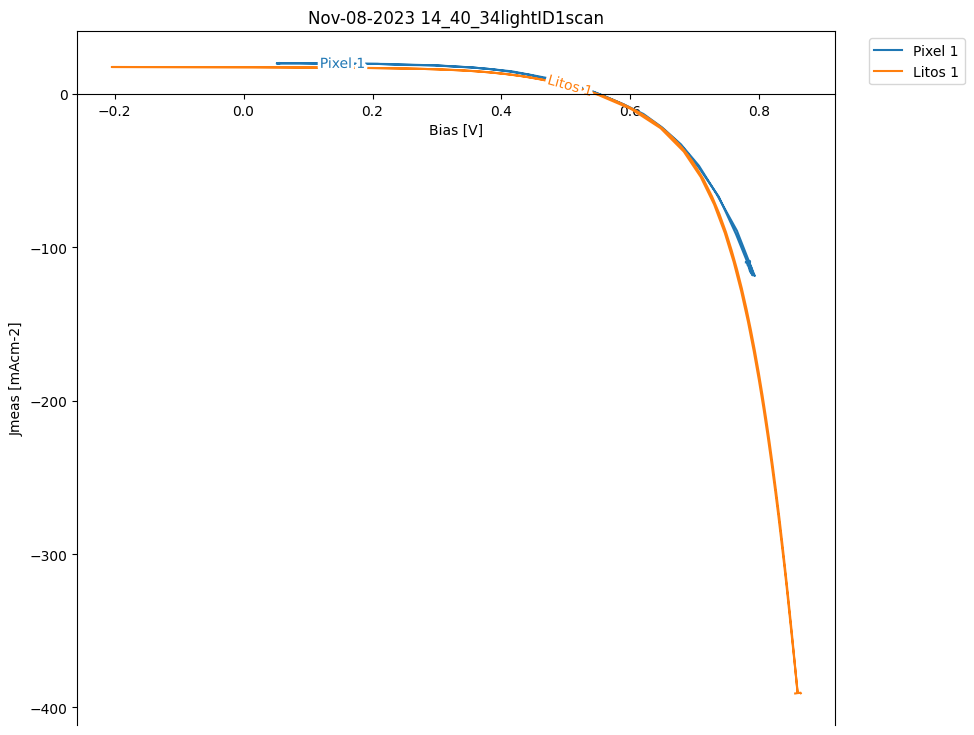

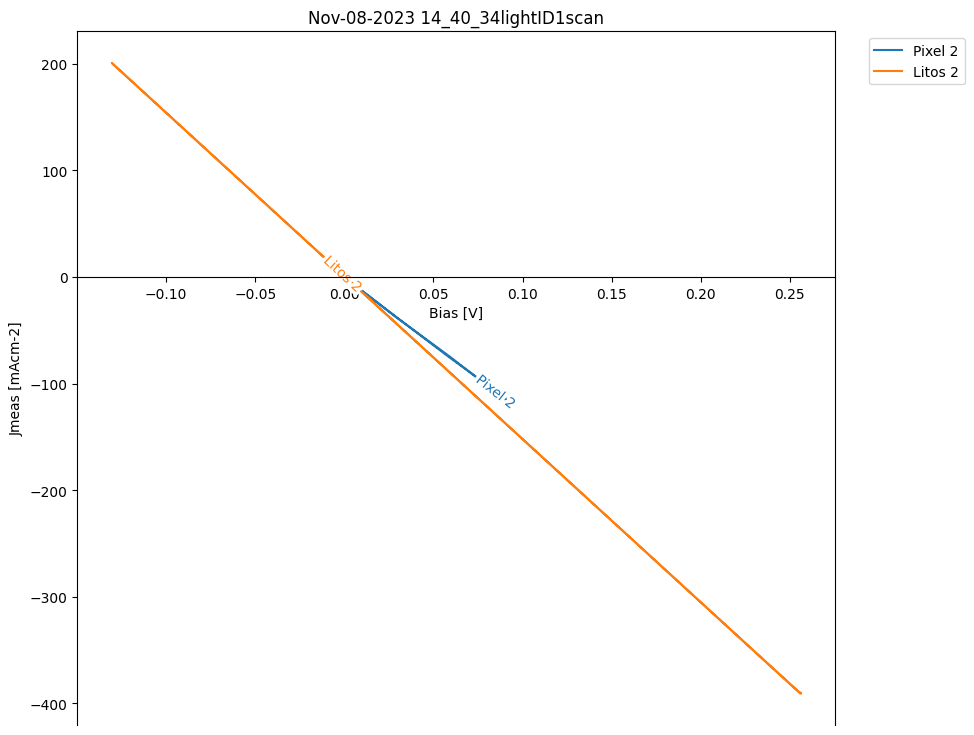

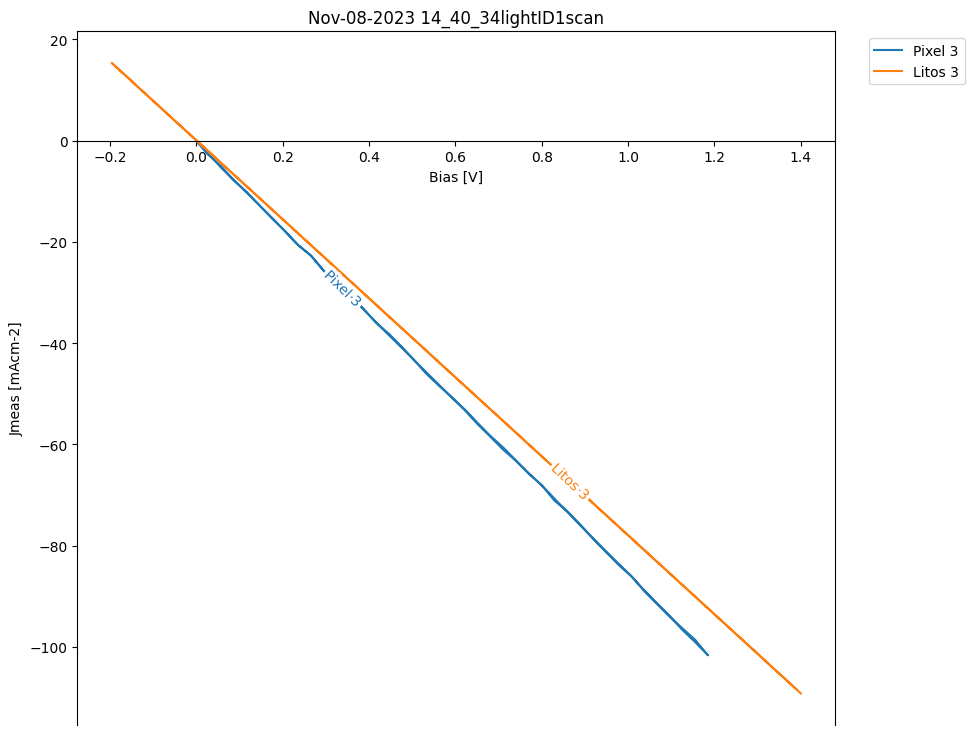

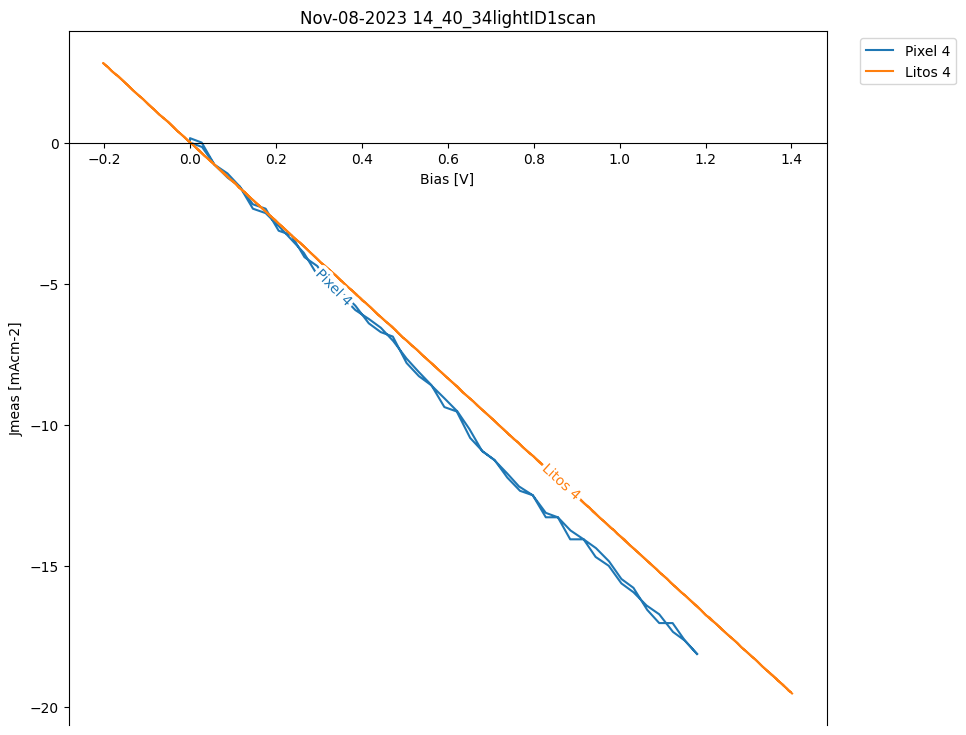

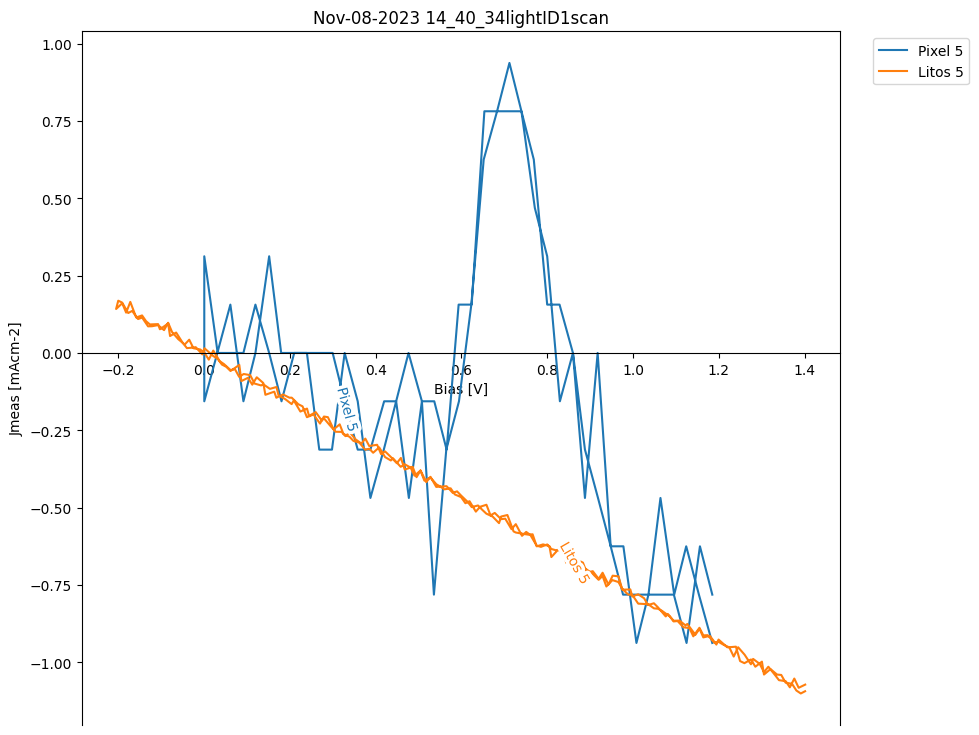

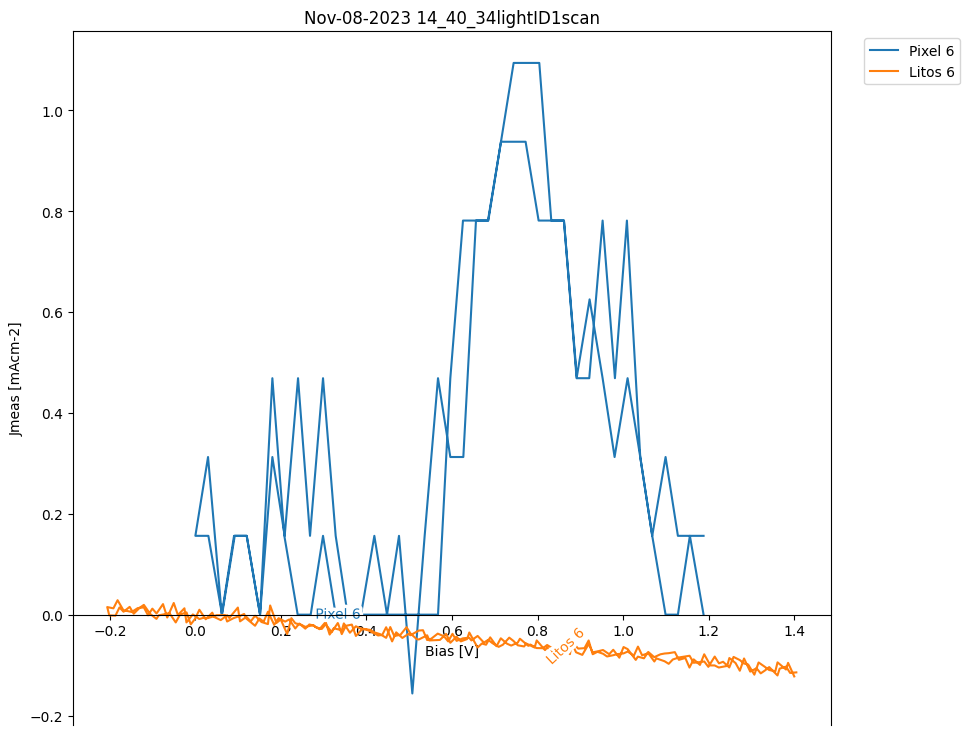

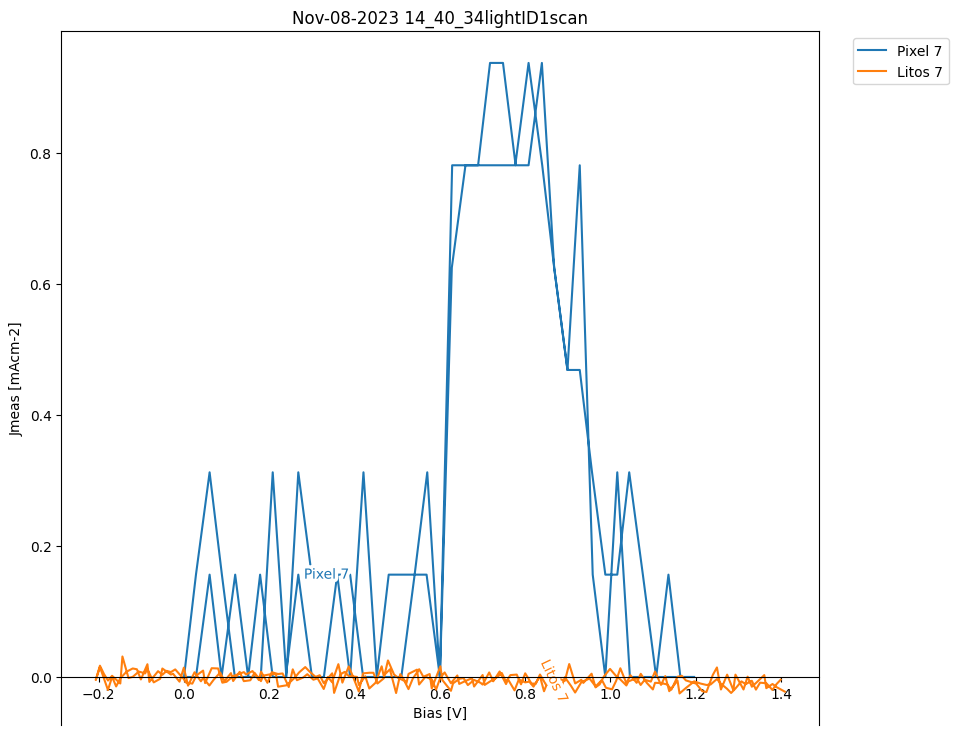

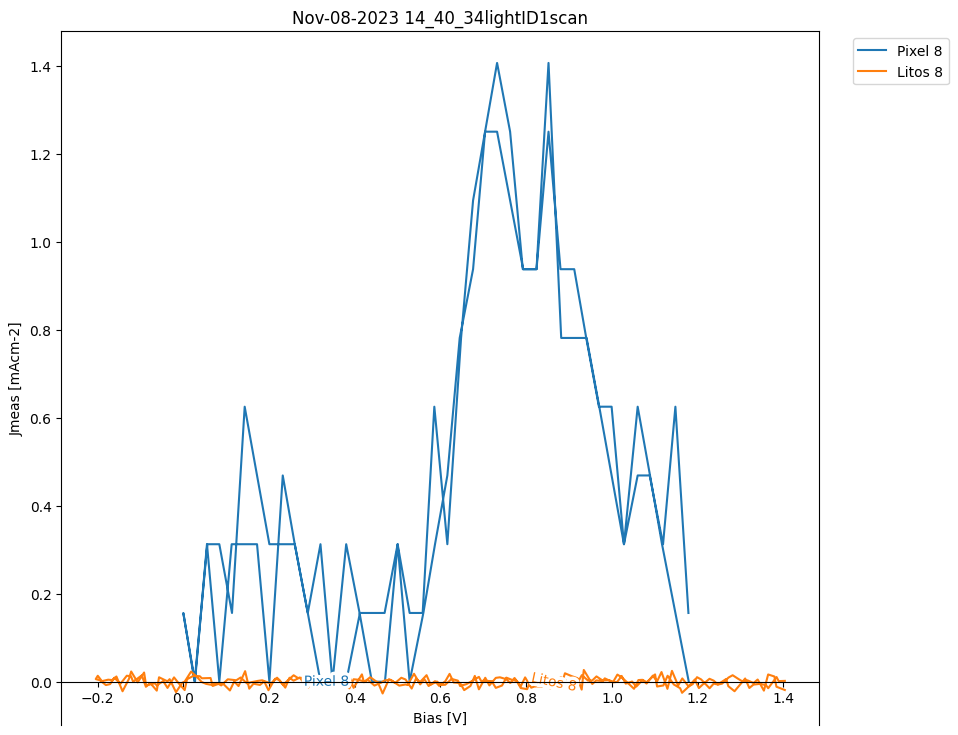

In [ ]:

litos_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\Litos_analyzed\100\Data\photo - 100p_1.0Sun_Scan0.txt"
ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\100p\Nov-08-2023 14_40_34lightID1scan.csv"

litos = np.loadtxt(litos_file_path,
					 delimiter="\t",
					 dtype=str)
litos = litos.T
litos = litos[:,1:].astype(float)

arr = np.loadtxt(ss_file_path,
					 delimiter=",",
					 dtype=str)
NUM_DEVICES = int((arr.shape[1]-2)/16)
device_to_pixels = {}
for i in range(NUM_DEVICES):
	device_to_pixels[i] = [j + 8*i for j in range(8)]

headers = arr[6,:]
header_dict = {value: index for index, value in enumerate(headers)}
arr = arr[7:, :]
voltage = arr[:, 2]
length = (len(headers) - 1)


jvList = []
for i in range(2, length): #remove timing and voltage output from array
	jvList.append(arr[:,i])

for i in range(0,len(jvList),2):
	# print(i)
	jvList[i] = [float(j) for j in jvList[i]]
	# jvList[i] = [float(v) - 5*float(j)*0.001 for v, j in zip(jvList[i], jvList[i+1])]
	jvList[i+1] = [float(x)/0.128 for x in jvList[i+1]]

# print(jvList)

plot_size = (10,8)
maxX = 1.3
minX = 0
maxY = 26
minY = -2

for i in range(0,len(litos),4):

	plot_title_orig = ss_file_path[:-4].split("\\")[-1]

	plt.figure(figsize=plot_size)
	# plt.xlim(minX,maxX)
	# plt.ylim(minY, maxY)
	plt.title(plot_title_orig)
	plt.xlabel('Bias [V]')
	plt.ylabel('Jmeas [mAcm-2]')
	# plt.ylabel('Jmeas [mA/cm]')
	plt.subplots_adjust(left=0.086, bottom=0.06, right=0.844, top=0.927, wspace=0.2, hspace=0.2)
	# print(dead_pixel, show_dead_pixels)
	# print(i)
	lineName = "Pixel " + str(int(i/4) + 1)
	# print(jvList[i],jvList[i+1])
	plt.plot(jvList[i//2],jvList[i//2+1], label = lineName)

	lineName = "Litos " + str(int(i/4) + 1)
	# print(litos[i],litos[i+1])

	plt.plot(np.concatenate((litos[len(litos)-(i+4)],litos[len(litos)-(i+2)])),np.concatenate((litos[len(litos)-(i+3)],litos[len(litos)-(i+1)])), label = lineName)

	ax = plt.gca()
	ax.spines['bottom'].set_position('zero')
	labelLines(plt.gca().get_lines(), zorder=2.5)

	plt.legend(bbox_to_anchor=(1.18, 1))
	plt.plot()

c:\Users\achen\miniforge3\envs\stabilitySetup\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 2 in `xvals` is outside the range of its associated line (xmin=0.0, xmax=0.0943, xval=1.3455882352941178). Clipping it into the allowed range.
  warnings.warn(


[]

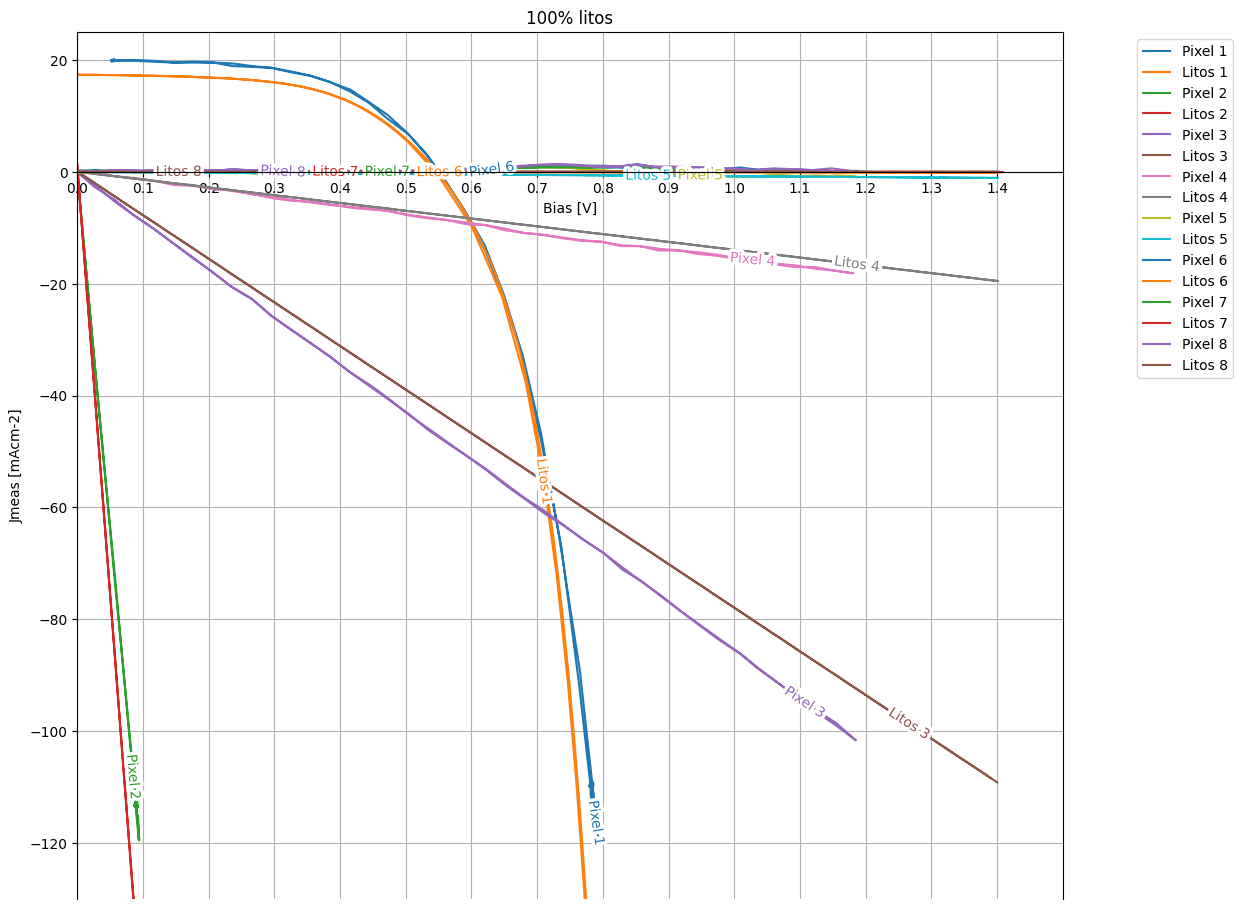

In [ ]:

# litos_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\Litos_analyzed\100\Data\photo - 100p_1.0Sun_Scan0.txt"
# ss_file_path = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\photodiodetest\100p\Nov-08-2023 14_40_34lightID1scan.csv"

litos = np.loadtxt(litos_file_path,
					 delimiter="\t",
					 dtype=str)
litos = litos.T
litos = litos[:,1:].astype(float)

arr = np.loadtxt(ss_file_path,
					 delimiter=",",
					 dtype=str)
NUM_DEVICES = int((arr.shape[1]-2)/16)
device_to_pixels = {}
for i in range(NUM_DEVICES):
	device_to_pixels[i] = [j + 8*i for j in range(8)]

headers = arr[6,:]
header_dict = {value: index for index, value in enumerate(headers)}
arr = arr[7:, :]
voltage = arr[:, 2]
length = (len(headers) - 1)


jvList = []
for i in range(2, length): #remove timing and voltage output from array
	jvList.append(arr[:,i])

for i in range(0,len(jvList),2):
	# print(i)
	jvList[i] = [float(j) for j in jvList[i]]
	# jvList[i] = [float(v) + 5*float(j)*0.001 for v, j in zip(jvList[i], jvList[i+1])]
	jvList[i+1] = [float(x)/0.128 for x in jvList[i+1]]




# print(jvList)

plot_size = (13,10)

maxX = 1.5
minX = 0
maxY = 25
minY = -130
plot_title_orig = "100% litos"

plt.figure(figsize=plot_size)
plt.xlim(minX,maxX)
plt.ylim(minY, maxY)
plt.title(plot_title_orig)
plt.xlabel('Bias [V]')
plt.ylabel('Jmeas [mAcm-2]')
# plt.ylabel('Jmeas [mA/cm]')
plt.subplots_adjust(left=0.086, bottom=0.06, right=0.844, top=0.927, wspace=0.2, hspace=0.2)

for i in range(0,len(litos),4):
	# print(dead_pixel, show_dead_pixels)
	# print(i)
	litos_volt = np.concatenate((litos[len(litos)-(i+4)],litos[len(litos)-(i+2)]))
	litos_curr = np.concatenate((litos[len(litos)-(i+3)],litos[len(litos)-(i+1)]))
	# break
	litos_pce = max(litos_volt*litos_curr)
	setup_pce = max(np.array(jvList[i//2])*np.array(jvList[i//2+1]))

	# diff = np.diff()

	lineName = "Pixel " + str(int(i/4) + 1)
	# print(jvList[i],jvList[i+1])
	plt.plot(jvList[i//2],jvList[i//2+1], label = lineName)

	lineName = "Litos " + str(int(i/4) + 1)
	# print(litos[i],litos[i+1])
	plt.plot(np.concatenate((litos[len(litos)-(i+4)],litos[len(litos)-(i+2)])),np.concatenate((litos[len(litos)-(i+3)],litos[len(litos)-(i+1)])), label = lineName)

	# plt.plot(np.concatenate((litos[len(litos)-(i+4)],litos[len(litos)-(i+2)])),np.concatenate((litos[len(litos)-(i+3)],litos[len(litos)-(i+1)])), label = lineName)
plt.xticks(np.arange(minX, maxX, 0.1))
ax = plt.gca()
ax.spines['bottom'].set_position('zero')
labelLines(plt.gca().get_lines(), zorder=2.5)
plt.grid()
plt.legend(bbox_to_anchor=(1.18, 1))
plt.plot()